<a href="https://colab.research.google.com/github/bdev-io/SOYBEAN/blob/main/SOY_BEAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
BASE_PATH = "/content/drive/MyDrive/crop"
CSV_FILE = "/content/drive/MyDrive/crop/data.csv"

Mounted at /content/drive


In [ ]:
!pip install colab_ssh --upgrade

from colab_ssh import launch_ssh_cloudflared, init_git_cloudflared
launch_ssh_cloudflared(password="snipershell!")

In [ ]:
# import kagglehub
# utathya_future_volume_prediction_path = kagglehub.dataset_download('utathya/future-volume-prediction')

# print('Data source import complete.')


100%|██████████| 531k/531k [00:00<00:00, 99.3MB/s]

Extracting files...
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
!pip install pytorch_forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [ ]:
data = pd.read_csv(CSV_FILE)
data = data.drop(columns=['Unnamed: 0'])
data_origin = data.copy()
data.head()
# data.size

print (data['state'].drop_duplicates())
print (data['crop'].drop_duplicates())

0      North Dakota
42     South Dakota
84         Nebraska
126          Kansas
168        Missouri
210        Arkansas
252     Mississippi
294            Ohio
336         Indiana
378        Illinois
420            Iowa
462       Wisconsin
504       Minnesota
Name: state, dtype: object
0     soybeans
21        corn
Name: crop, dtype: object


In [ ]:
#from pytorch_forecasting.data.examples import get_stallion_data

#data = get_stallion_data()


#data_origin = data.copy()

In [ ]:
#data = pd.read_parquet("/kaggle/input/stallion/stallion.parquet")


df = data_origin
df["time_idx"] = df["year"] - df["year"].min()
df["group"] = df["state"] + "_" + df["crop"]


data = df.copy()

print (data.shape)

(546, 88)


In [ ]:
df

,target,state,year,crop,area,ndvi_1,ndvi_17,ndvi_33,ndvi_49,ndvi_65,...,temp_305,temp_313,temp_321,temp_329,temp_337,temp_345,temp_353,temp_361,time_idx,group
0,33.5,North Dakota,2001,soybeans,2150000,-122.538,-214.272,-213.254,-217.498,682.852,...,14261.334,14322.296,14163.436,13642.882,13538.665,13432.687,13243.590,12922.187,0,North Dakota_soybeans
1,33.0,North Dakota,2002,soybeans,2670000,1403.378,403.376,1442.808,1988.787,1132.954,...,13908.839,13802.472,13913.661,13770.797,13628.559,13847.344,13017.994,13301.362,1,North Dakota_soybeans
2,29.0,North Dakota,2003,soybeans,3150000,460.362,124.444,89.070,223.286,1495.452,...,13190.139,13560.216,13665.805,13437.337,13376.106,13091.654,13509.886,12872.187,2,North Dakota_soybeans
3,23.0,North Dakota,2004,soybeans,3750000,-126.944,-96.872,-269.606,-283.778,211.704,...,14074.946,14033.510,13960.308,13611.019,13583.629,13662.843,13491.902,13331.316,3,North Dakota_soybeans
4,36.5,North Dakota,2005,soybeans,2950000,-54.288,532.700,1071.120,1161.004,1436.910,...,14147.837,14211.745,13901.456,13448.038,12962.760,13565.456,13340.081,13725.257,4,North Dakota_soybeans
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,47.5,Minnesota,2017,soybeans,8150000,567.558,615.720,1288.109,1831.220,2500.335,...,13584.654,13606.306,13670.277,13805.654,13509.400,13310.792,13105.405,12480.281,16,Minnesota_soybeans
542,49.0,Minnesota,2018,soybeans,7750000,955.072,1005.745,797.453,373.599,448.504,...,14009.420,13638.532,13328.109,13364.327,13352.076,13617.792,13360.545,12798.123,17,Minnesota_soybeans
543,44.0,Minnesota,2019,soybeans,6850000,951.611,606.862,317.693,333.812,187.465,...,13580.098,13478.269,13656.959,13257.648,13414.089,12887.880,13337.381,13167.397,18,Minnesota_soybeans
544,50.0,Minnesota,2020,soybeans,7450000,438.422,331.998,280.665,251.008,1080.465,...,14254.699,14520.200,13703.022,13692.064,13796.279,13623.221,13273.848,13082.104,19,Minnesota_soybeans


In [ ]:


# add time index
# data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
# data["time_idx"] -= data["time_idx"].min()

# add additional features
# data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
# data["log_volume"] = np.log(data.volume + 1e-8)
# data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
# data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
# special_days = [
#     "easter_day",
#     "good_friday",
#     "new_year",
#     "christmas",
#     "labor_day",
#     "independence_day",
#     "revolution_day_memorial",
#     "regional_games",
#     "fifa_u_17_world_cup",
#     "football_gold_cup",
#     "beer_capital",
#     "music_fest",
# ]
# data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

,target,state,year,crop,area,ndvi_1,ndvi_17,ndvi_33,ndvi_49,ndvi_65,...,temp_305,temp_313,temp_321,temp_329,temp_337,temp_345,temp_353,temp_361,time_idx,group
471,162.0,Wisconsin,2010,corn,3900000,717.885,611.729,603.251,528.562,3388.136,...,14146.833,14227.518,13631.942,13410.944,13237.563,12952.227,13171.326,13332.409,9,Wisconsin_corn
394,201.0,Illinois,2017,corn,11200000,3345.515,3319.497,3174.810,3293.662,3484.270,...,14269.955,14064.593,14042.202,14285.859,13944.281,13842.863,13907.453,13209.899,16,Illinois_corn
135,124.0,Kansas,2010,corn,4850000,1726.711,2704.187,2458.417,2533.948,2814.796,...,14727.475,14465.699,14249.216,14163.703,14122.579,13866.658,13951.823,14183.194,9,Kansas_corn
370,55.5,Indiana,2014,soybeans,5450000,1743.368,840.946,691.960,1575.944,2621.519,...,14212.179,13893.854,13556.757,13937.958,13749.565,13843.581,13886.272,13612.928,13,Indiana_soybeans
520,194.0,Minnesota,2017,corn,8050000,567.558,615.720,1288.109,1831.220,2500.335,...,13584.654,13606.306,13670.277,13805.654,13509.400,13310.792,13105.405,12480.281,16,Minnesota_corn
130,135.0,Kansas,2005,corn,3650000,1731.030,3041.341,3105.518,3200.978,3369.233,...,14701.745,14473.124,14361.799,14197.352,13620.768,13976.667,14018.828,14165.117,4,Kansas_corn
125,63.0,Nebraska,2021,soybeans,5600000,1600.540,2164.978,693.900,2251.814,2424.334,...,14515.270,14313.207,14227.790,14317.124,14163.395,13.924,14007.347,13768.727,20,Nebraska_soybeans
96,169.0,Nebraska,2013,corn,9950000,982.750,1992.066,2065.900,1931.868,2077.846,...,14284.950,14264.448,14236.315,13995.734,13120.693,13739.475,13736.844,14000.781,12,Nebraska_corn
505,157.0,Minnesota,2002,corn,7200000,1826.117,1229.210,1851.776,1482.802,779.150,...,13899.805,13665.221,13832.641,13433.251,13448.669,13770.944,13240.872,13438.647,1,Minnesota_corn
62,134.0,South Dakota,2021,corn,6150000,1457.918,1846.465,1429.336,2184.502,2216.780,...,14347.672,14170.898,13986.644,14077.625,13877.434,13607.305,13677.503,13274.718,20,South Dakota_corn


In [ ]:
data.describe()


,target,year,area,ndvi_1,ndvi_17,ndvi_33,ndvi_49,ndvi_65,ndvi_81,ndvi_97,...,temp_297,temp_305,temp_313,temp_321,temp_329,temp_337,temp_345,temp_353,temp_361,time_idx
count,546.000000,546.000000,5.460000e+02,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,...,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000
mean,98.645604,2011.000000,5.277902e+06,2326.302106,2144.771396,2075.014509,2290.497139,2787.149575,3316.526355,3928.688201,...,14378.338740,14362.137582,14112.951198,14101.958894,13847.837729,13723.923348,13624.575487,13653.629418,13479.705267,10.000000
std,58.108814,6.060853,3.333537e+06,1601.521413,1576.826880,1559.971205,1523.544309,1326.898879,1291.187404,1323.809723,...,906.191366,298.049684,1248.469311,311.431504,1228.660937,915.897281,1238.472976,903.306222,1484.775690,6.060853
min,23.000000,2001.000000,1.900000e+02,-326.034000,-382.208000,-396.734000,-349.724000,-333.928000,-57.396000,-175.080000,...,14.033000,13190.139000,14.486000,13189.437000,13.515000,14.398000,13.924000,13.446000,13.817000,0.000000
25%,45.000000,2006.000000,3.200000e+06,951.611000,805.974000,709.817000,973.950000,2135.926000,2472.444000,2944.636000,...,14291.154000,14175.970000,14053.957000,13906.622000,13756.172000,13509.564000,13463.369000,13454.469000,13305.960000,5.000000
50%,70.000000,2011.000000,4.750000e+06,2344.268000,1966.671000,1951.423000,2251.814000,2836.897000,3201.933000,3815.204000,...,14449.874000,14403.766000,14257.980000,14137.611000,13974.795000,13804.400000,13770.944000,13770.909000,13693.097000,10.000000
75%,155.000000,2016.000000,7.200000e+06,3436.811000,3246.358000,3110.238000,3307.139000,3508.060000,4053.344000,4576.673000,...,14601.440000,14567.004000,14417.674000,14326.507000,14182.670000,14057.885000,14031.758000,13951.823000,13972.176000,15.000000
max,210.000000,2021.000000,1.420000e+07,5790.374000,5663.881000,5575.756000,5472.006000,5530.305000,6830.830000,7465.649000,...,15010.224000,15040.649000,14756.920000,14808.273000,14598.522000,14661.503000,14568.663000,14501.054000,14709.264000,20.000000


In [ ]:
max_prediction_length = 2
max_encoder_length = 10 # 몇년치 데이터를 반영할지임.
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    #data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="target",
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["state", "crop"],
    static_reals=["area"],
    time_varying_known_reals=[col for col in df.columns if "ndvi_" in col or "prec_" in col or "temp_" in col],
    time_varying_unknown_reals=["target"],
    #variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    #time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    # time_varying_unknown_reals=[
    #     "volume",
    #     "log_volume",
    #     "industry_volume",
    #     "soda_volume",
    #     "avg_max_temp",
    #     "avg_volume_by_agency",
    #     "avg_volume_by_sku",
    # ],
    target_normalizer=GroupNormalizer(
        groups=["group"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

print (training)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)

val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

TimeSeriesDataSet[length=520](
	time_idx='time_idx',
	target='target',
	group_ids=['group'],
	weight=None,
	max_encoder_length=10,
	min_encoder_length=5,
	min_prediction_idx=0,
	min_prediction_length=1,
	max_prediction_length=2,
	static_categoricals=['state', 'crop'],
	static_reals=['area'],
	time_varying_known_categoricals=None,
	time_varying_known_reals=['ndvi_1', 'ndvi_17', 'ndvi_33', 'ndvi_49', 'ndvi_65', 'ndvi_81', 'ndvi_97', 'ndvi_113', 'ndvi_129', 'ndvi_145', 'ndvi_161', 'ndvi_177', 'ndvi_193', 'ndvi_209', 'ndvi_225', 'ndvi_241', 'ndvi_257', 'ndvi_273', 'ndvi_289', 'ndvi_305', 'ndvi_321', 'ndvi_337', 'ndvi_353', 'prec_1', 'prec_32', 'prec_60', 'prec_91', 'prec_121', 'prec_152', 'prec_182', 'prec_213', 'prec_244', 'prec_274', 'prec_305', 'prec_335', 'temp_1', 'temp_9', 'temp_17', 'temp_25', 'temp_33', 'temp_41', 'temp_49', 'temp_57', 'temp_65', 'temp_73', 'temp_81', 'temp_89', 'temp_97', 'temp_105', 'temp_113', 'temp_121', 'temp_129', 'temp_137', 'temp_145', 'temp_153', 'temp_161

In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(8.4038, device='cuda:0')

In [ ]:
## (*•؎ •*) 은하수를 여행하는 히치하이커 (*•؎ •*) ##

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=True, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger(os.path.join(BASE_PATH, 'tf_logger'))  # logging results to a tensorboard

pl.seed_everything(42)

## (*•؎ •*) 은하수를 여행하는 히치하이커 (*•؎ •*) ##

trainer = pl.Trainer(
    max_epochs=50,
    max_steps=50,
    #accelerator="cpu", # tpu / cuda
    # accelerator="cuda",
    # accelerator="cpu",
    # accelerator=,
    enable_model_summary=False,
    gradient_clip_val=0.1,
    limit_train_batches=100,
    # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    log_every_n_steps=1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=42,
    attention_head_size=2,
    dropout=0.25,
    hidden_continuous_size=16, # 연속 변수의 표현 차원수
    loss=QuantileLoss(),
    log_interval=8,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    log_val_interval=10,  # uncomment for best val on last log_val_interval evaluations
    # optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 596.9k


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 4.996
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 4.996


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=50` reached.


In [ ]:
!pip install optuna==3.5.0 statsmodels optuna-integration[pytorch_lightning]
import optuna
from optuna.integration import PyTorchLightningPruningCallback
#import pytorch_lightning as pl
import pytorch_lightning as pl
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import LearningRateMonitor
#import lightning.pytorch as pl
from pytorch_forecasting.metrics import QuantileLoss

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
              

In [ ]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# 파라미터 튜닝

study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=3, # 몇번 시도할지
    max_epochs=10,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,
    verbose=2,
    # use Optuna to find ideal learning rate or use in-built learning rate finder
)

with open(os.path.join(BASE_PATH, "test_study.pkl"), "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2025-04-22 15:24:15,077] A new study created in memory with name: no-name-44ed0c83-b09d-438d-b23a-8d2486aca46b
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:142: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gradient_clip_val = trial.suggest_loguniform(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:168: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugg

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-04-22 15:25:34,171] Trial 0 finished with value: 5.726761817932129 and parameters: {'gradient_clip_val': 0.034913506764759974, 'hidden_size': 126, 'dropout': 0.2232174415507851, 'hidden_continuous_size': 37, 'attention_head_size': 3, 'learning_rate': 0.01668997284268872}. Best is trial 0 with value: 5.726761817932129.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/optuna_test/trial_1 exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-04-22 15:26:48,837] Trial 1 finished with value: 6.211501121520996 and parameters: {'gradient_clip_val': 0.27284955481113016, 'hidden_size': 10, 'dropout': 0.22280180210115874, 'hidden_continuous_size': 8, 'attention_head_size': 3, 'learning_rate': 0.005175302802754283}. Best is trial 0 with value: 5.726761817932129.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/optuna_test/trial_2 exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-04-22 15:27:04,161] Trial 2 pruned. Trial was pruned at epoch 1.


{'gradient_clip_val': 0.034913506764759974, 'hidden_size': 126, 'dropout': 0.2232174415507851, 'hidden_continuous_size': 37, 'attention_head_size': 3, 'learning_rate': 0.01668997284268872}


In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
# best_model_path = "/content/drive/MyDrive/crop/tf_logger/lightning_logs/version_6/checkpoints/epoch=10-step=110.ckpt"
print (best_model_path)


best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/content/drive/MyDrive/crop/tf_logger/lightning_logs/version_8/checkpoints/epoch=3-step=50.ckpt


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [ ]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


tensor(7.1021)

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True, return_index=True)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x350 with 1 Axes>,
 'encoder_variables': <Figure size 700x2275 with 1 Axes>,
 'decoder_variables': <Figure size 700x2250 with 1 Axes>}

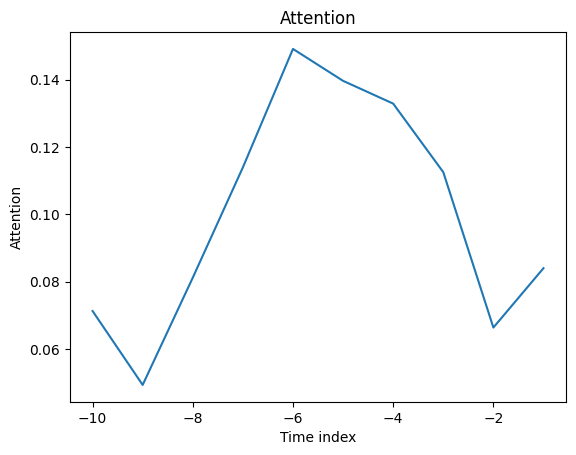

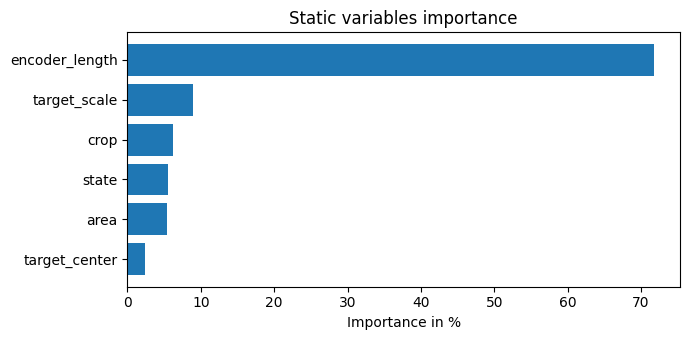

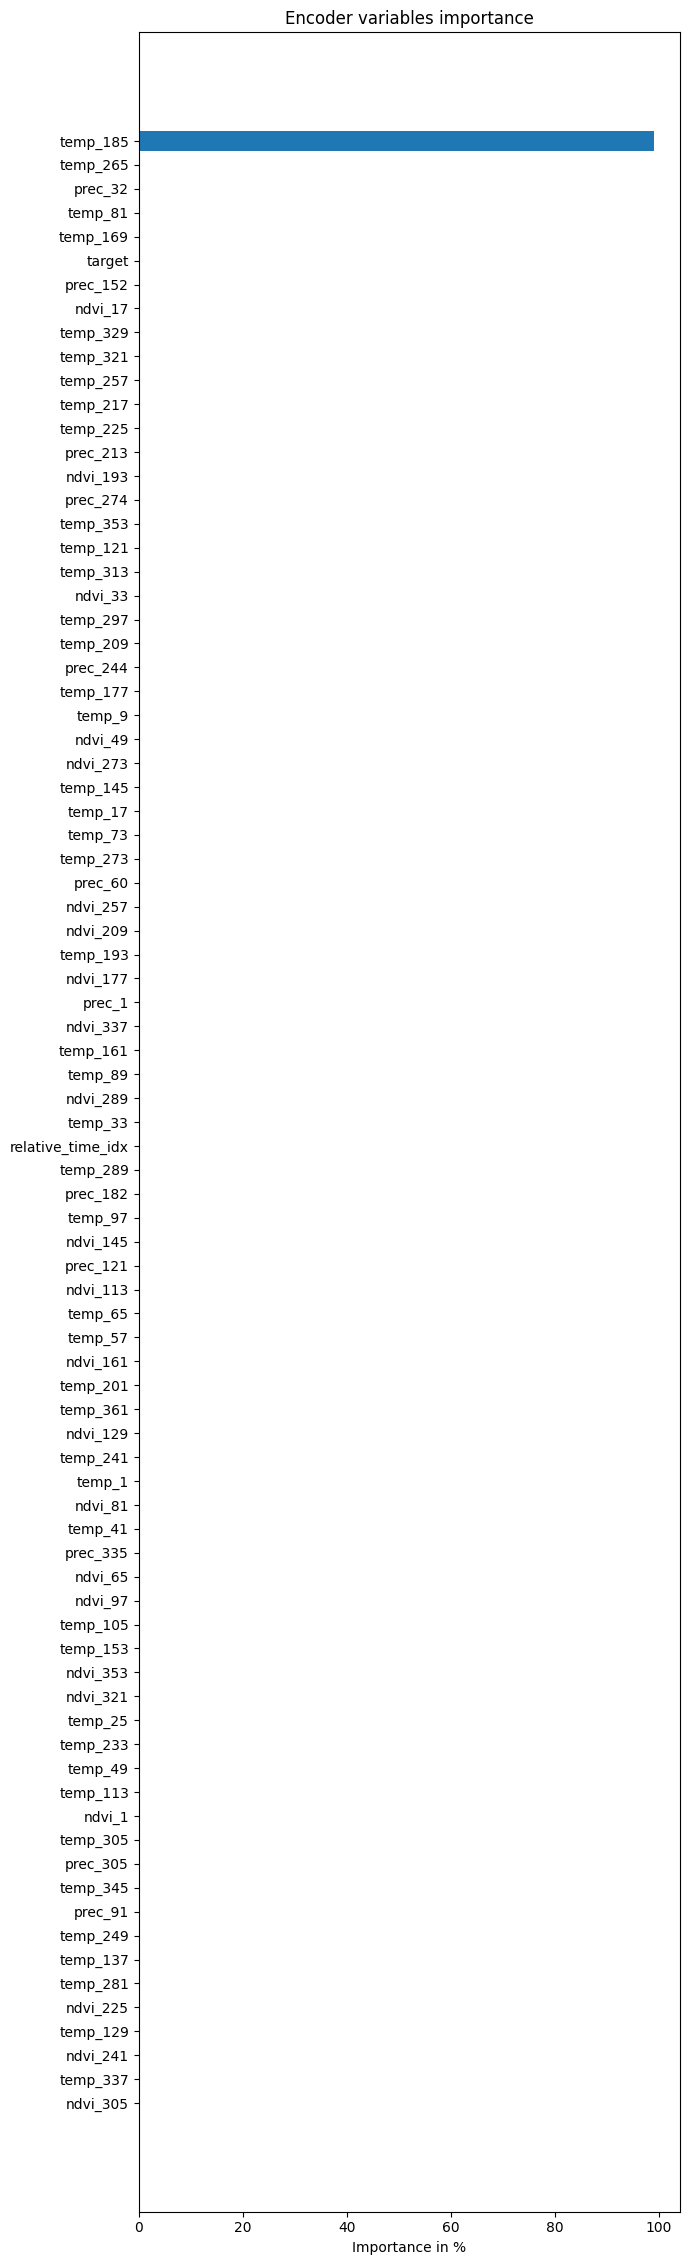

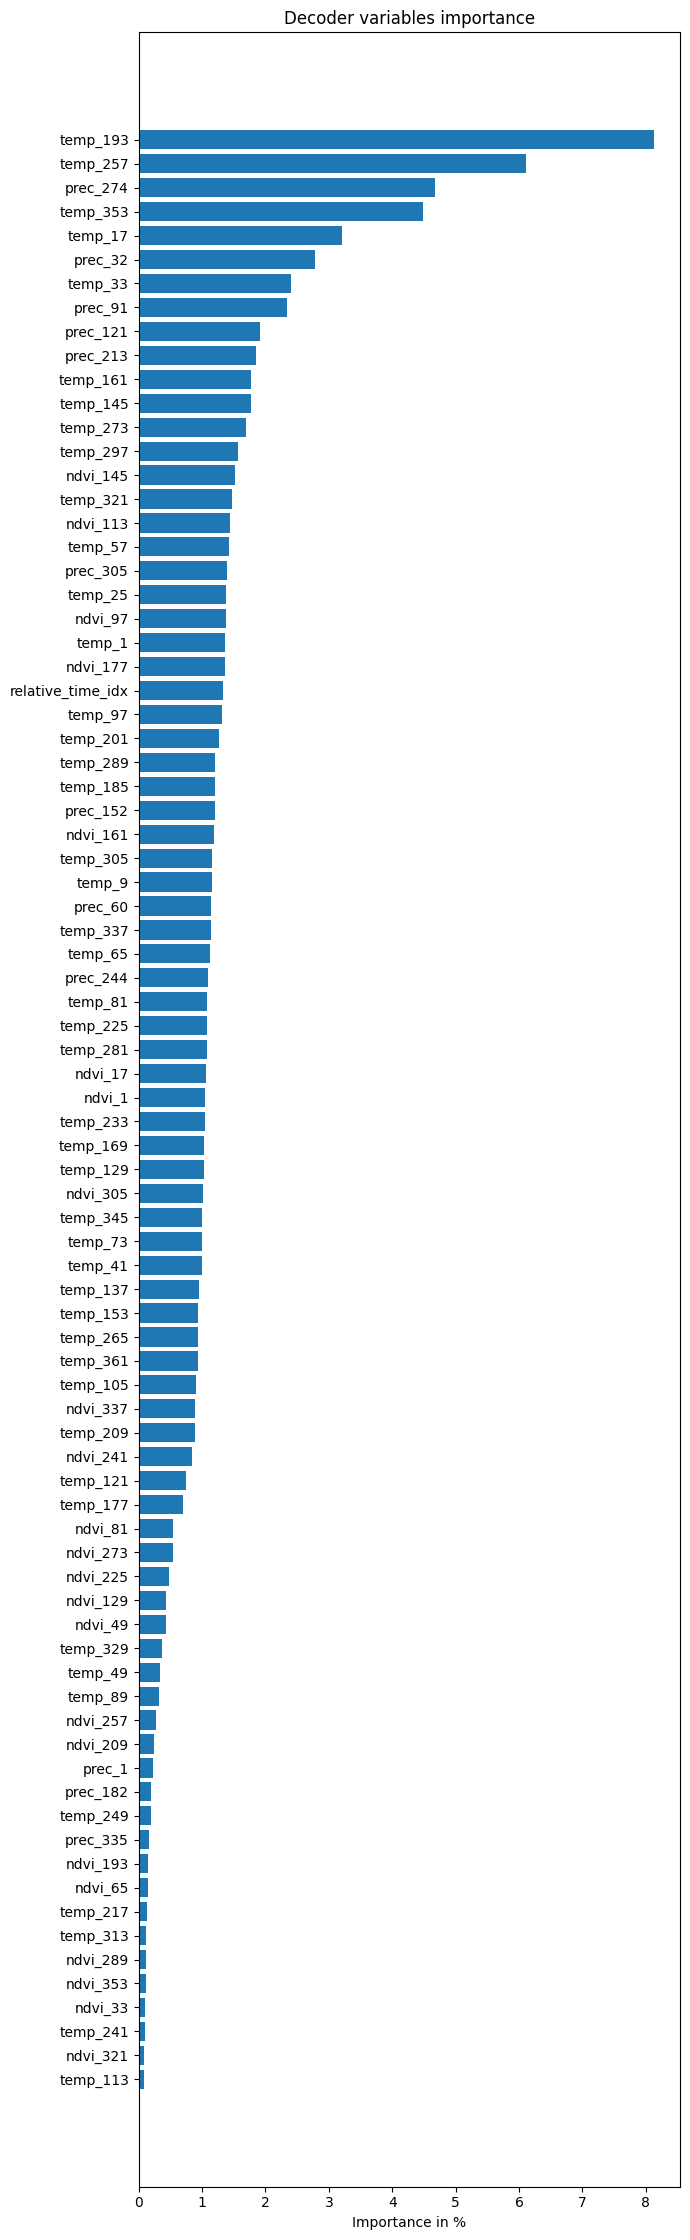

In [ ]:
#print (raw_predictions.output.shape)
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

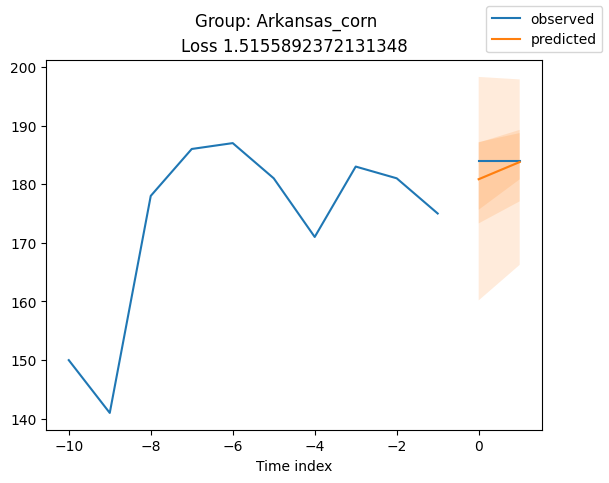

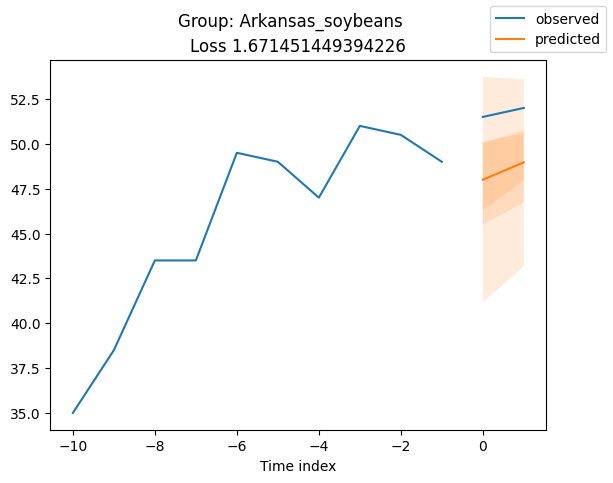

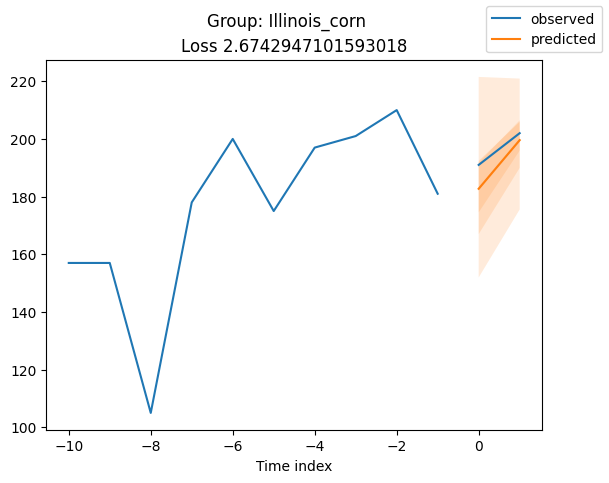

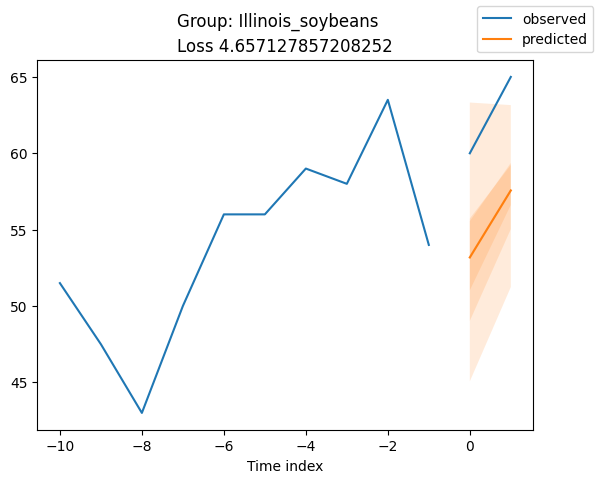

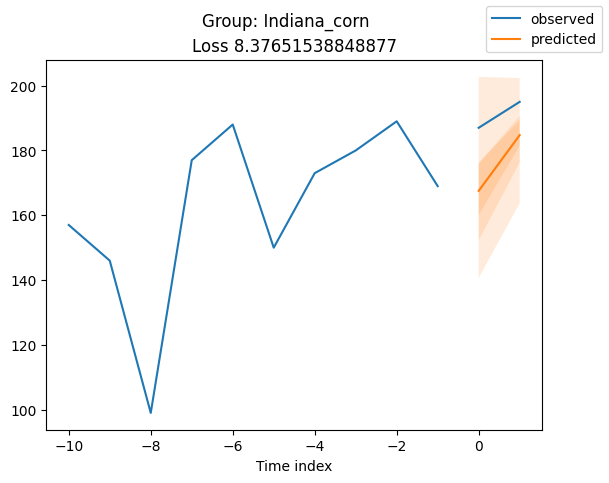

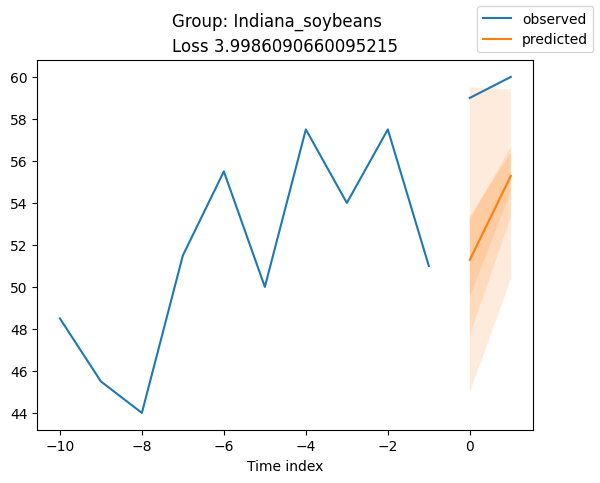

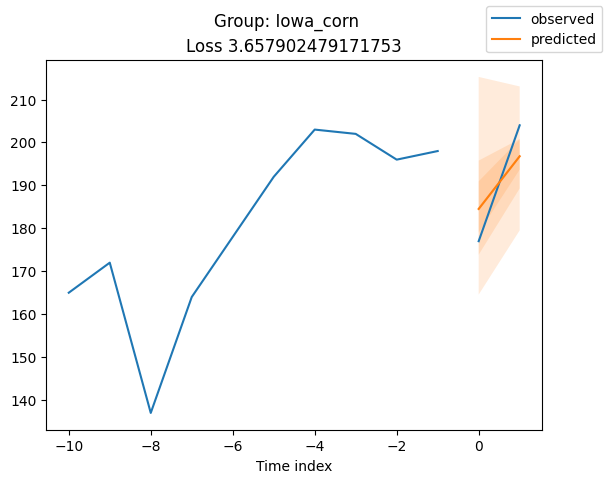

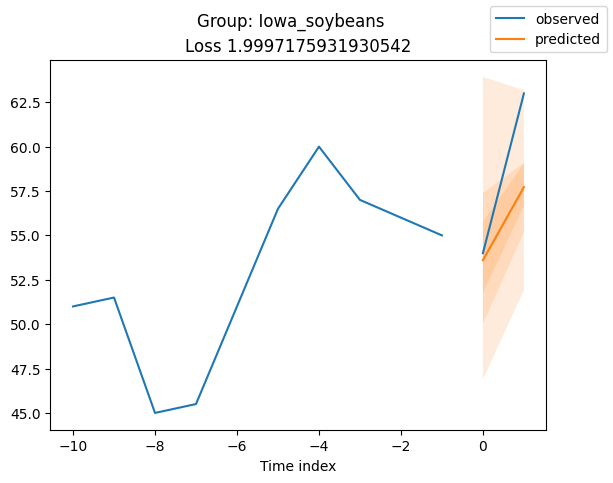

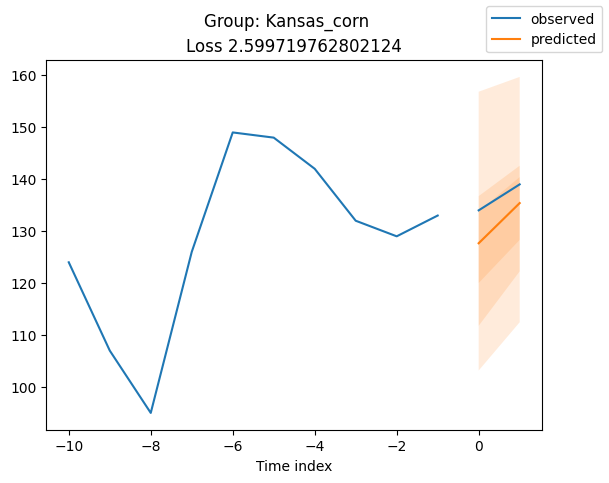

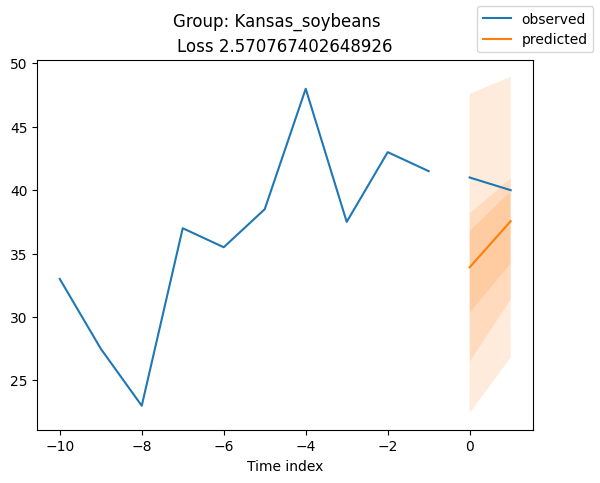

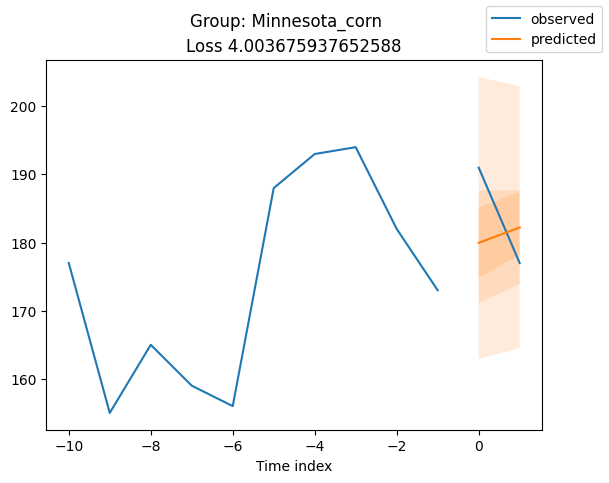

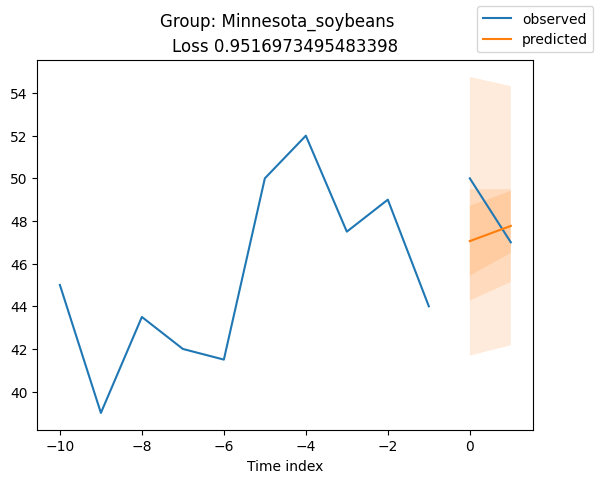

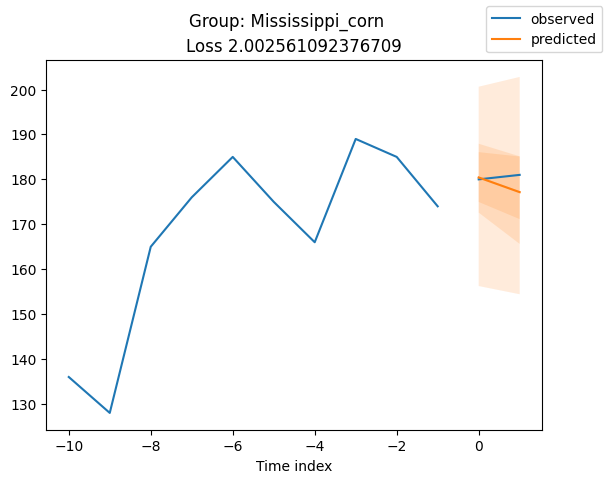

In [ ]:

# best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, add_loss_to_title=True, idx=0)
# print('1')
# best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, add_loss_to_title=True, idx=1)

for idx in range(13):  # plot 10 examples
  plot_ind = best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True, show_future_observed=True, plot_attention=False)
  idx_name = (raw_predictions.index['group'][idx])
  plot_ind.suptitle(f"Group: {idx_name}")
  # plot_ind.set(title=f"Group: {idx_name}")
  plot_ind.show()

In [ ]:
from pytorch_forecasting.metrics import SMAPE

# calcualte metric by which to display
#predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))

#print (predictions.output)

#y_pred = predictions.y[0].cpu()



# 예측
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"), return_index=True)

# 예측값과 실제값 (둘 다 CPU로 옮겨서 계산)
y_pred = predictions.output.cpu()
y_true = predictions.y[0].cpu()

# SMAPE 인스턴스 생성
smape = SMAPE()

print (y_pred)
print (y_true)
# 전체 평균 SMAPE 계산
smape_score = smape(y_pred, y_true)

print(f"📊 SMAPE (전체 평균): {smape_score * 100:.2f}%")



# mean_losses = SMAPE(reduction="none")(predictions.output, predictions.y).mean(1)
# indices = mean_losses.argsort(descending=True)  # sort losses
# for idx in range(10):  # plot 10 examples
    # best_tft.plot_prediction(
    #     raw_predictions.x,
    #     raw_predictions.output,
    #     idx=indices[idx],
    #     add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
    # )

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


tensor([[180.8443, 183.7735],
        [ 47.9993,  48.9670],
        [182.7231, 199.5826],
        [ 53.1807,  57.5668],
        [167.5344, 184.7386],
        [ 51.2908,  55.2865],
        [184.5181, 196.7877],
        [ 53.6031,  57.7219],
        [127.6674, 135.3993],
        [ 33.9230,  37.5531],
        [179.9533, 182.2124],
        [ 47.0574,  47.7687],
        [180.4253, 177.1560],
        [ 51.1621,  50.1413],
        [155.2247, 169.0917],
        [ 44.1273,  47.1708],
        [169.0881, 175.4530],
        [ 52.8467,  55.2925],
        [122.3736, 131.5434],
        [ 32.2553,  34.7012],
        [167.0076, 181.5703],
        [ 50.2240,  54.0452],
        [130.9679, 139.0890],
        [ 38.3535,  40.7417],
        [168.6777, 168.0495],
        [ 50.3377,  50.1015]])
tensor([[184.0000, 184.0000],
        [ 51.5000,  52.0000],
        [191.0000, 202.0000],
        [ 60.0000,  65.0000],
        [187.0000, 195.0000],
        [ 59.0000,  60.0000],
        [177.0000, 204.0000],
        [

In [ ]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)